# $\chi^2$ and maximum likelihood fits

In [1]:
from uncertainties import ufloat, unumpy
from scipy.stats import norm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display, Math

In [2]:
mpl.rcParams["figure.figsize"] = (10, 6)
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["axes.labelsize"] = 20

In this notebook we will show several ways to adjust model to a set of experimental data.

## linear regression with $\chi^2$ (least square) fit:

We plan to fit a linear model

$$ f(x) = ax + b \hspace{2cm} \big(= f(x;\vec \theta); \vec{\theta} = (a, b) \big)$$

to a set of N measurements 

$$ \{y_i(x_i) \pm \sigma_i; i = 1,..., N\} $$

where $\sigma_i$ is the uncertainty of measurement $i$. We want to determine $a$ and $b$.

Our dataset is generated from a  noisy linear model with $a=4$ and $b=10$.

In [3]:
x = np.linspace(1, 25, 20)

a = 4.0
b = 10.0
sigma = 4.0

def f(x, a, b):
    return a * x + b

def generate_data(x, a, b, sigma, random_state=100):
    """
    generate data from linear model and add noise to it
    """
    def getshift(random_state, sigma):
        rnd = np.random.RandomState(random_state)
        randn = rnd.randn(x.size)
        sign = np.sign(randn)
        shift = np.where(np.abs(randn) < 0.5, sign*0.5, randn) * sigma * np.abs(rnd.normal(1.0, 0.25, x.size))
        return shift
    shift = getshift(random_state, sigma*0.5)
    error = getshift(random_state*28, sigma)
    y = unumpy.uarray(f(x, a, b) + shift, np.abs(error))
    return y

y = generate_data(x, a, b, sigma)

Here is a plot of thegenerated data with the **true** model (non noisy) used to generated it. We have 20 measurements for $x = 1, ..., 25$.

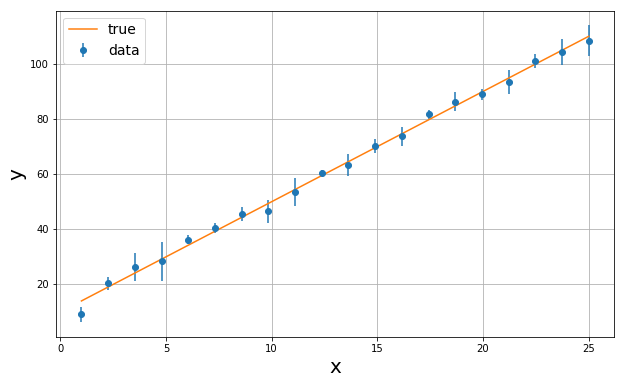

In [4]:
plt.errorbar(x, unumpy.nominal_values(y), yerr=unumpy.std_devs(y), fmt="o", label="data")
plt.plot(x, f(x, a, b), label="true")
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

We define the normalised distance $(y_i -f(x_i)) / \sigma_i$, and write the $\chi^2$ function

$$ \chi^2 = \sum_{i=1}^{N} \frac{(y_i -f(x_i))^2}{\sigma_i^2}$$

The goal is to find the set of parameter, $\hat{\theta}$, that minimises the $\chi^2$ function.

The $\chi^2$ function is constructed below using our data and depends only on the parameter $a$ and $b$.

In [5]:
def chi2function(x, y):
    def eval_(a, b):
        y_ = unumpy.nominal_values(y)
        y_err = unumpy.std_devs(y)
        return np.sum(np.square( (y_ - f(x, a, b)) / y_err ))
    return np.vectorize(eval_)

In [6]:
chi2 = chi2function(x, y)

Below is the contour plot of the $\chi^2$ function for different values of $a$ and $b$ showing the minimum seats where $a \approx 4$ and $b \approx 10$ as expected.

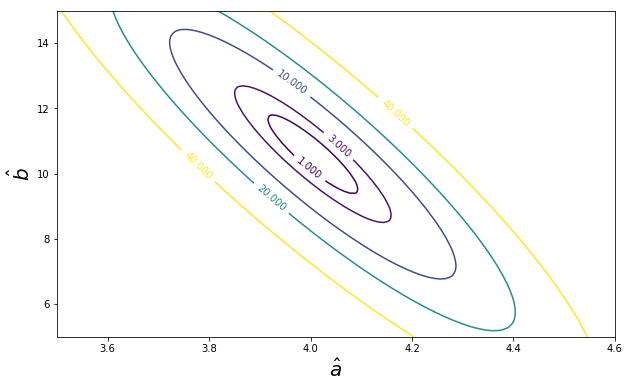

In [7]:
from matplotlib import cm

fig, ax = plt.subplots()

an = np.linspace(3.5, 4.6, 100)
bn = np.linspace(5.0, 15.0, 100)
An, Bn = np.meshgrid(an, bn)
CS = ax.contour(An, Bn, chi2(An, Bn) - np.min(chi2(An, Bn)), levels=[1, 3, 10, 20, 40])
ax.set_xlabel("$\hat{a}$")
ax.set_ylabel("$\hat{b}$")
ax.clabel(CS, inline=1, fontsize=10);

We now minimize the $\chi^2$ function using a minimiser from [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

In [8]:
from scipy.optimize import minimize

result_chi2 = minimize(lambda x: chi2(x[0], x[1]), [4.0, 10.])

In [9]:
result_chi2

      fun: 8.361685709884917
 hess_inv: array([[ 0.00398527, -0.04841637],
       [-0.04841637,  0.73251877]])
      jac: array([-7.15255737e-07, -1.19209290e-07])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([ 4.00439531, 10.5986988 ])

In [10]:
print(f"fit result:\n \t a = {result_chi2.x[0]}\n \t b = {result_chi2.x[1]}\n")

fit result:
 	 a = 4.004395308514954
 	 b = 10.598698798206792



The quality (goodness) of the fit is estimated as

\begin{equation}
\begin{split}
 & \gg 1.0 & \hspace{0.5cm} \Rightarrow \text{poor fit} \\
\frac{\chi^2(\hat{\theta})}{\text{ndof}} \hspace{0.5cm} & \approx 1.0 & \hspace{0.5cm}  \Rightarrow \text{good fit} \\
 & \ll 1.0 & \hspace{0.5cm} \Rightarrow \text{too good fit, the unertainties are overestimated} 
\end{split}
\end{equation}

where ndof is the number of degrees of freedom and is given by the number of measurements, N, minus the number of free parameter is the fit. In our case we get:

In [11]:
ndof = x.size - 2
chi2ndof = chi2(result_chi2.x[0], result_chi2.x[1])/ (ndof)
print(f"chi2/ndof = {chi2ndof:.3f}")

chi2/ndof = 0.465


We plot the result of the fit with the data.

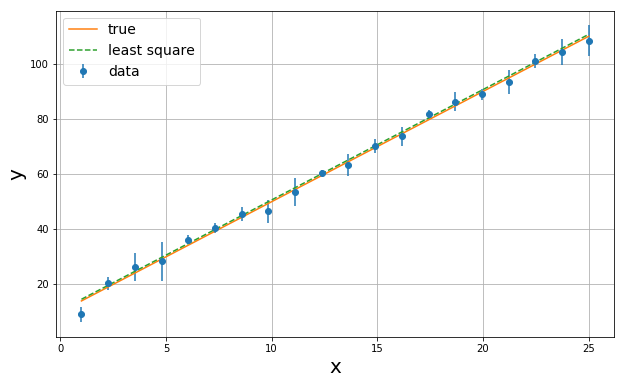

In [12]:
plt.errorbar(x, unumpy.nominal_values(y), yerr=unumpy.std_devs(y), fmt="o", label="data")
plt.plot(x, f(x, a, b), label="true")
plt.plot(x, f(x, result_chi2.x[0], result_chi2.x[1]), "--", label="least square")
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

Uncertainties of the estimated parameters ($\pm1\sigma$) are given by the interval in which the $\chi2$ increases by $1.0$, in the normal distribution hypothesis (Gaussian uncertainties), the uncertainty is related to the seconde derivative of the $\chi^2$ function, and is equal to

$$
\sigma_{\hat{\theta}}^2 = \bigg\{ \frac{1}{2} \frac{\partial^2\chi^2}{\partial \theta^2}  \bigg|_{\theta = \hat{\theta}} \bigg\}^{-1}.
$$

We first compute the uncertainty using the gaussian approximation and see if it matches the uncertainty we obtain with interval in which the $\chi2$ increases by $1.0$ graphically.

In [13]:
def diff2(x, cost):
    """
    double derivative of cost function
    """
    diff = np.gradient(cost, np.diff(x)[0])
    diff2 = np.gradient(diff, np.diff(x)[0])
    return diff2

In [14]:
d2chi_d2a = diff2(an, chi2(an, result_chi2.x[1]))
d2chi_d2b = diff2(bn, chi2(result_chi2.x[0], bn))

In [15]:
arg_a = np.abs(an - result_chi2.x[0]).argmin()
arg_b = np.abs(bn - result_chi2.x[1]).argmin()

In [16]:
sigma_a = np.sqrt(1 / (0.5 * d2chi_d2a))[arg_a]
display(Math("\sigma_{\hat{a}} " + f"= {sigma_a:.4f}"))

<IPython.core.display.Math object>

In [17]:
sigma_b = np.sqrt(1 / (0.5 * d2chi_d2b))[arg_b]
display(Math("\sigma_{\hat{b}} " + f"= {sigma_b:.4f}"))

<IPython.core.display.Math object>

In [18]:
def profile_plot(param, values, cost):
    """
    plot the profile of the cost function for the `param` and plot the 1 sigma band.
    """
    fig, ax = plt.subplots()
    rdchi2 = cost - np.min(cost)
    mid = rdchi2.argmin()
    band = [values[np.abs(rdchi2[np.where(values < values[mid])] - 1.0).argmin()],
            values[np.abs(rdchi2[np.where(values > values[mid])] - 1.0).argmin() + mid + 1]]
    ax.fill_betweenx(np.linspace(0., np.max(rdchi2), 100), band[0], band[1], facecolor='mediumseagreen', alpha=0.5)
    text = f'${param} = {values[mid]:.3f}' + '^{' + f'+{band[1] - values[mid]:.3f}'
    text += '}_{' + f'-{values[mid] - band[0]:.3f}' + '}$'
    ax.text(0.3, 0.75, text, fontsize=18, transform=ax.transAxes)
    ax.plot(values, rdchi2)
    ax.set_xlabel("$\hat{" + param + "}$")
    ax.grid();  
    return f, ax

We do the profile plot of the $\chi^2$ function in function of $a$ and $b$ and estimate the errors.

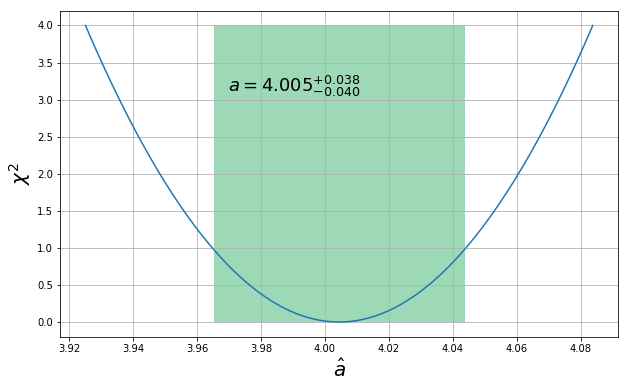

In [19]:
an = np.linspace(result_chi2.x[0] - 2*sigma_a, result_chi2.x[0] + 2*sigma_a, 100)
fig, ax = profile_plot("a", an, chi2(an, result_chi2.x[1]))
ax.set_ylabel("$\chi^2$");

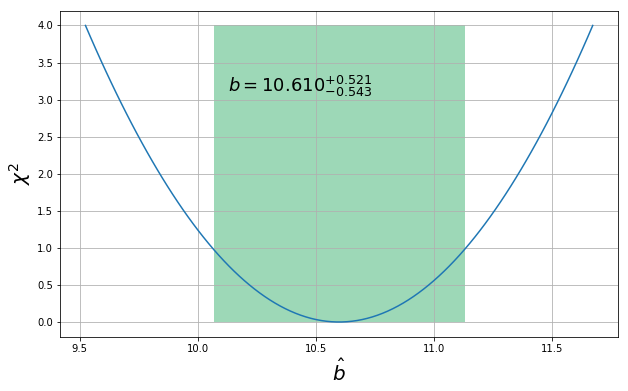

In [20]:
bn = np.linspace(result_chi2.x[1] - 2*sigma_b, result_chi2.x[1] + 2*sigma_b, 100)
fig, ax = profile_plot("b", bn, chi2(result_chi2.x[0], bn))
ax.set_ylabel("$\chi^2$");

So we get very similar errors. 

Least square fit is not only used for linear regression, but also for curve fitting and distributions.

## maximum likelihood fit on gaussian distribution:

We plan to fit a distribution (probability density function, **pdf**) on some data.

We generate data, 1000 events, from a gaussian distribution of mean 10. and width 2. We will then adjust a gaussian pdf

$$
G(x; \mu, \sigma) = \frac{1}{\sqrt{2\pi}\sigma} \exp\bigg({-0.5 \times \frac{(x - \mu)^2}{\sigma^2}}\bigg)
$$

and extract the $\mu$ and $\sigma$ parameter.

In [21]:
data = np.random.normal(10, 2., 1000)

In [22]:
def pdf(x, mu, sigma):
    t = (x - mu) / sigma
    pdf = np.exp(-0.5 * t**2)
    pdf /= np.sqrt(2 * np.pi) * sigma
    return pdf   

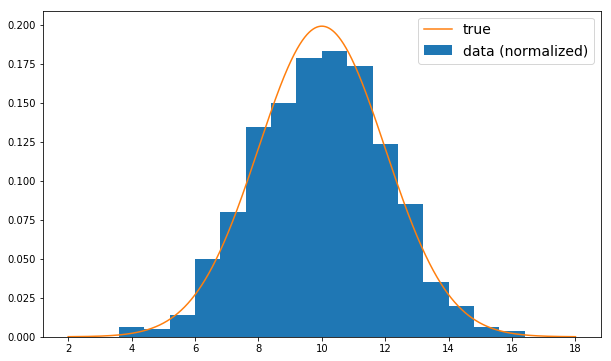

In [23]:
plt.hist(data, bins=20, density=True, range=(2.0, 18), label="data (normalized)");
z = np.linspace(2.0, 18, 10000)
plt.plot(z, pdf(z, 10, 2.), label="true")
plt.ylabel("density")
plt.ylabel("density")
plt.legend();

To estimate the best set of parameters we will use the likelihood

$$\mathcal{L}(\vec{\theta}) = \prod_{i=1}^{N} \mathcal{P}(x_i; \vec{\theta}) = \prod_{i=1}^{N} G(x_i; \mu, \sigma) $$ 

The best parameter $\tilde{\theta}$ is obtained when the likelihood is maximised. For computionnal reasons it's to take the negative log of the likelihood defined:

$$ NLL(\mu, \sigma) = -2 \ln \mathcal{L} (\mu, \sigma) =  -2 \sum_{i=1}^{N}\ln G(x_i; \mu, \sigma)$$

The NLL (negative log-likelihood) is constructed below from our data and depends only on the $\mu$ and $\sigma$ parameters.

In [24]:
def NLL_function(data):
    def eval_(mu, sigma):
        return - 2 * np.sum(np.log(pdf(data, mu, sigma)))
    return np.vectorize(eval_)

In [25]:
nll = NLL_function(data)

As for the least square feat we plot the contour of the NLL function for different values of $\mu$ and $\sigma$ and we see that the minimum seats where $\mu \approx 9.8$ and $\sigma \approx 2.0$. You can try to add more events to the dataset (10000) and see what happens in this plot.

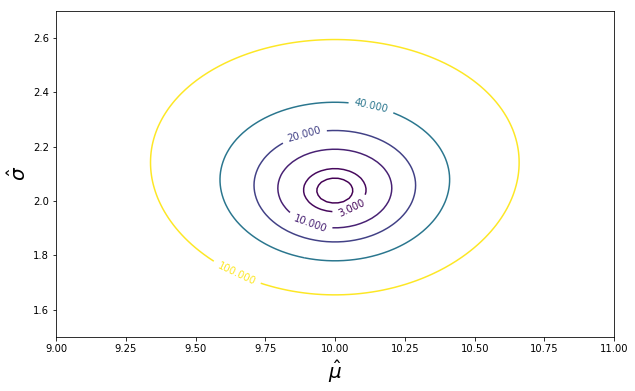

In [26]:
fig, ax = plt.subplots()

mun = np.linspace(9, 11, 100)
sigman = np.linspace(1.5, 2.7, 100)
MUn, SIGMAn = np.meshgrid(mun, sigman)
CS = ax.contour(MUn, SIGMAn, nll(MUn, SIGMAn) - np.min(nll(MUn, SIGMAn)), levels=[1, 3, 10, 20, 40, 100])
ax.clabel(CS, inline=1, fontsize=10)
ax.set_xlabel("$\hat{\mu}$")
ax.set_ylabel("$\hat{\sigma}$");

We minimise the NLL function using the same minimiser. 

In [27]:
result_nll = minimize(lambda x: nll(x[0], x[1]), [10.0, 2.])

In [28]:
result_nll

      fun: 4260.797718958708
 hess_inv: array([[0.00061861, 0.00057103],
       [0.00057103, 0.00058689]])
      jac: array([ 0.00000000e+00, -6.10351562e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 65
      nit: 8
     njev: 16
   status: 2
  success: False
        x: array([9.99863338, 2.03696367])

In [29]:
print("fit result:")
display(Math("\t \hat{\mu}" + f" = {result_nll.x[0]:.3f}"))
display(Math("\t \hat{\sigma}" + f" = {result_nll.x[1]:.3f}"))

fit result:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In a maximum likelihood fit case the variance on one estimator is given by:

$$
\hat{V}(\hat{\theta}) = \bigg\{ \frac{1}{2} \frac{\partial^2 NLL}{\partial \theta^2}  \bigg|_{\theta = \hat{\theta}} \bigg\}^{-1} = \sigma^2_{\hat{\theta}}
$$



(True if $\hat{\theta}$ is *asymptotically* Normally distributed when $N \rightarrow +\infty$, see [Rao-Cramér-Frechet minimum variance bound.](https://en.wikipedia.org/wiki/Cramér–Rao_bound)). The uncertainties are:

In [30]:
d2nll_d2mu = diff2(mun, nll(mun, result_nll.x[1]))
d2nll_d2sigma = diff2(sigman, nll(result_nll.x[0], sigman))

In [31]:
arg_mu = np.abs(mun - result_nll.x[0]).argmin()
arg_sigma = np.abs(sigman - result_nll.x[1]).argmin()

In [32]:
sigma_mu = np.sqrt(1 / (0.5 * d2nll_d2mu))[arg_mu]
display(Math("\sigma_{\hat{\mu}} " + f"= {sigma_mu:.4f}"))

<IPython.core.display.Math object>

In [33]:
sigma_sigma = np.sqrt(1 / (0.5 * d2nll_d2sigma))[arg_sigma]
display(Math("\sigma_{\hat{\sigma}} " + f"= {sigma_sigma:.4f}"))

<IPython.core.display.Math object>


The error can also be found graphically. If you Taylor expand the NLL around the minimum you get

$$
NLL(\theta) \; \approx \; NLL(\hat{\theta}) \; + \; \underbrace{\frac{\partial NLL}{\partial \theta }\bigg|_{\theta=\hat{\theta}}}_{=0} \times (\hat{\theta} - \theta)  \; + \; \frac{1}{2}\frac{\partial^2 NLL}{\partial \theta^2 }\bigg|_{\theta=\hat{\theta}} \times (\hat{\theta} - \theta)^2 
$$

$$
\Rightarrow NLL(\theta) \; \approx \; NLL(\hat{\theta}) \;   \; + \; \frac{(\hat{\theta} - \theta)^2}{\sigma_{\theta}^2}
$$

And the if you evaluate in $\hat{\theta} \pm \sigma_{\theta}$:

$$
NLL(\hat{\theta} \pm \sigma_{\theta}) \; \approx \; NLL(\hat{\theta}) \; + \; 1
$$

So from this uncertainties of the estimated parameters ($\pm1\sigma$) are given by the interval in which the NLL increases by $1.0$. This can be check in the two following plots.

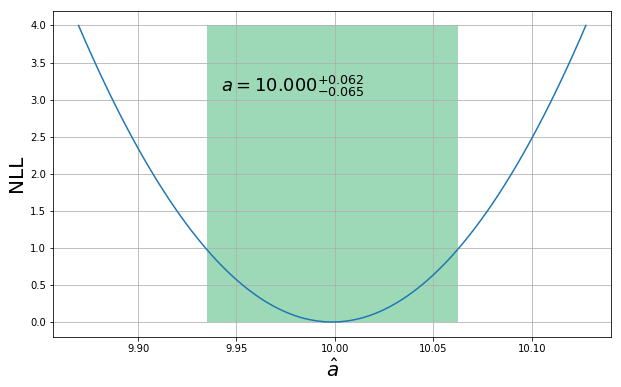

In [34]:
mun = np.linspace(result_nll.x[0] - 2*sigma_mu, result_nll.x[0] + 2*sigma_mu, 100)
fig, ax = profile_plot("a", mun, nll(mun, result_nll.x[1]))
ax.set_ylabel("NLL");

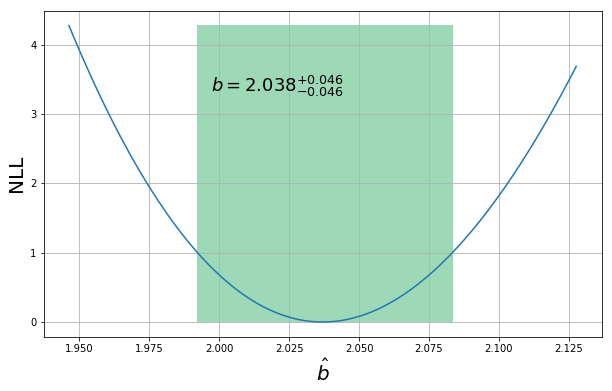

In [35]:
sigman = np.linspace(result_nll.x[1] - 2*sigma_sigma, result_nll.x[1] + 2*sigma_sigma, 100)
fig, ax = profile_plot("b", sigman, nll(result_nll.x[0], sigman))
ax.set_ylabel("NLL");

## linear regression with maximum likelihood fit:

Going back to the linear regression as the beggining of the notebook, we will now try to to extract the best parameters using the negative log likelihood.

Our estimators for the linear regression are:

$$
\hat{y_i} = \hat{a} \,x_i + \hat{b}
$$

We now make the assumption that $y_i \sim G\big(x_i; \; f(x_i; a, b), \; \sigma_i\big) $ and the NLL is given by:

\begin{equation}
\begin{split}
NLL_{reg}(a, b) & = -2\ln\mathcal{L}(a, b) = -2 \sum_{i=1}^{N} \ln G\big(x_i; \; f(x_i; a, b), \; \sigma_i\big) \\
 & = -2 \sum_{i=1}^{N} \bigg[-\frac{(y_i -f(x_i; a, b))^2}{2\sigma_i^2} \underbrace{-\ln\sigma_i - \ln\sqrt{2\pi}}_{= \text{ constant}} \bigg] \\
  & = \sum_{i=1}^{N} \frac{(y_i -f(x_i; a, b))^2}{\sigma_i^2} + \text{ constant} \\
  & = \chi^2 + \text{ constant}
\end{split}
\end{equation}

We retrieve the $\chi^2$ function. The maximum likelihood method is therefore a more general method, from which we can derive the $\chi^2$ minimisation method, but which can also be used for ther probability distributions. For example, for counting experiments, the measurements follow the Poisson distribution.

We now also understand why

$$
\sigma_{\hat{\theta}}^2 = \bigg\{ \frac{1}{2} \frac{\partial^2\chi^2}{\partial \theta^2}  \bigg|_{\theta = \hat{\theta}} \bigg\}^{-1}.
$$

and 

$$
\chi^2(\hat{\theta} \pm \sigma_{\theta}) \; \approx \; \chi^2(\hat{\theta}) \; + \; 1.
$$

As a little game we can redo the linear fit using the NLL, which is constructed with the function below, minimise it and check that we get the same estimation for $a$ and $b$ (values and uncertainties).

In [36]:
def NLL_regression(x, y):
    def eval_(a, b):
        y_ = unumpy.nominal_values(y)
        y_err = unumpy.std_devs(y)
        return - 2 * np.sum(np.log(pdf(f(x, a, b), y_, y_err)))
    return np.vectorize(eval_)

In [37]:
nll_reg = NLL_regression(x, y)

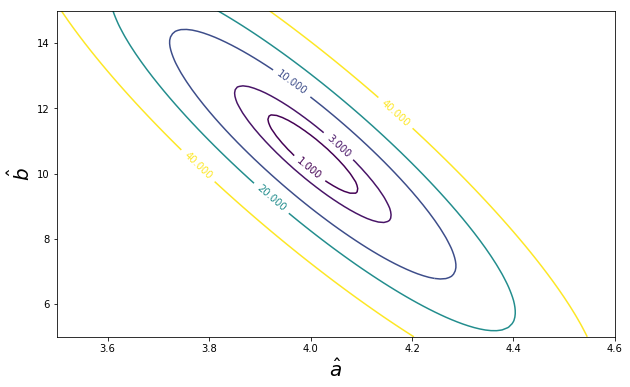

In [38]:
fig, ax = plt.subplots()

an = np.linspace(3.5, 4.6, 100)
bn = np.linspace(5.0, 15.0, 100)
An, Bn = np.meshgrid(an, bn)
CS = ax.contour(An, Bn, nll_reg(An, Bn) - np.min(nll_reg(An, Bn)), levels=[1, 3, 10, 20, 40])
ax.set_xlabel("$\hat{a}$")
ax.set_ylabel("$\hat{b}$")
ax.clabel(CS, inline=1, fontsize=10);

In [39]:
result_nll_reg = minimize(lambda x: nll_reg(x[0], x[1]), [4.0, 10.])
result_nll_reg

      fun: 89.45014330388335
 hess_inv: array([[ 0.00398526, -0.04841627],
       [-0.04841627,  0.73251738]])
      jac: array([ 0.00000000e+00, -9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([ 4.00439534, 10.59869833])

In [40]:
d2nll_d2a = diff2(an, nll_reg(an, result_nll_reg.x[1]))
d2nll_d2b = diff2(bn, nll_reg(result_nll_reg.x[0], bn))

In [41]:
arg_a = np.abs(an - result_nll_reg.x[0]).argmin()
arg_b = np.abs(bn - result_nll_reg.x[1]).argmin()

In [42]:
sigma_a = np.sqrt(1 / (0.5 * d2nll_d2a))[arg_a]
display(Math("\sigma_{\hat{a}} " + f"= {sigma_a:.4f}"))

<IPython.core.display.Math object>

In [43]:
sigma_b = np.sqrt(1 / (0.5 * d2nll_d2b))[arg_b]
display(Math("\sigma_{\hat{b}} " + f"= {sigma_b:.4f}"))

<IPython.core.display.Math object>

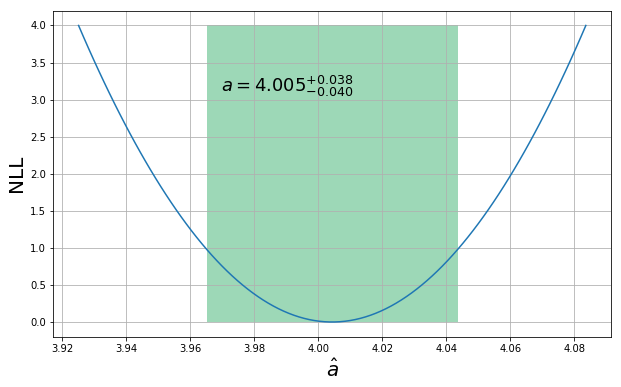

In [44]:
an = np.linspace(result_nll_reg.x[0] - 2*sigma_a, result_nll_reg.x[0] + 2*sigma_a, 100)
fig, ax = profile_plot("a", an, nll_reg(an, result_nll_reg.x[1]))
ax.set_ylabel("NLL");

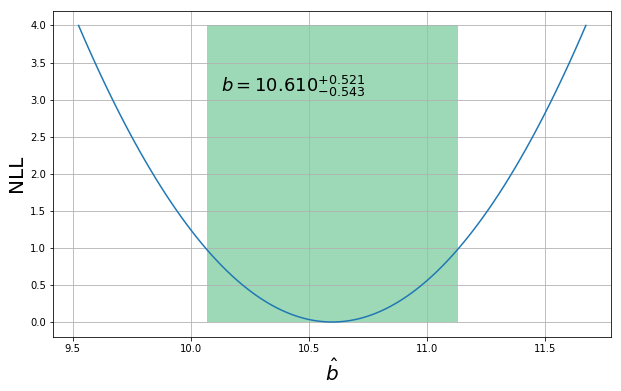

In [45]:
bn = np.linspace(result_nll_reg.x[1] - 2*sigma_b, result_nll_reg.x[1] + 2*sigma_b, 100)
fig, ax = profile_plot("b", bn, nll_reg(result_nll_reg.x[0], bn))
ax.set_ylabel("NLL");